## The PDE's

The rate of absorption of a gas into a spherical particle of radius $R$ will be described by

$$
\frac{\partial q}{\partial t} = \mathcal{D} \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2\frac{\partial q}{\partial r}\right) = -\frac{1}{r^2}\frac{\partial r^2J}{\partial r}
$$

with boundary conditions:

$$
q_r|_{r=0} = 0; \quad q|_{r=R} = q^*(c).
$$

Here, $q^*$ is the equilibrium saturation concentration inside the particle, which will depend on the continuous-phase concentration, c, via a Langmuir Isotherm:

$$
\frac{q}{q_{max}} = \frac{bc}{1+bc}.
$$

Firstly, we will create a model of absorption at constant external pressure (i.e. concentration, $c$).

## Discretisation (constant P)

We divide the spherical particle into $N$ concentric radial shells, with mean concentration (which we take to be the central concentration $q_i$. For each of these, we discretise the PDE above:

$$
\dot{q_i} = -\frac{\mathcal{D}}{r_i^2}\left(\frac{r^2_{i+1/2}J_{i+1/2}-r^2_{i-1/2}J_{i-1/2}}{\Delta r}\right)
$$

In turn, we estimate the fluxes via a midpoint method

$$
J_{i+1/2} = -\mathcal{D}\frac{q_{i+1}-q_i}{\Delta r}
$$

The boundary conditions are simply

$$
J_{1/2} = 0
$$

and

$$
q_{N+1/2} = q^*
$$
which for now we treat as a constant. In order to calculate $J_{N+1/2}$, we will use the slightly crude one-sided approximation, $J_{N+1/2}\approx -\mathcal{D} (q^*-q_N)/(\Delta r/2)$

This is a very simple discretisation scheme. From memory, Paul and one of his PhD students did some more sophisticated analysis of this exact problem, probably with more accurate discretisation methods. We then feed this to a ODE solver.

In [5]:
using DifferentialEquations

(D,R,qstar) = [1,1,1]
function dqdt(t,q)
    N = length(q)
    Δr = R/N
    r = Δr/2:Δr:(R-Δr/2)
    qdot = zeros(N)
    J = zeros(N+1)
    rboundary = zeros(N+1)
    rboundary[1] = 0
    rboundary[N+1] = R
    q[1] = q[2]
    J[N] = -D*(qstar-q[N])/(Δr/2)
    for i = 1:N-1
        J[i] = -D*(q[i+1]-q[i])/Δr
        rboundary[i] = (r[i+1]+r[i])/2
    end
    for i = 2:N
        qdot[i] = -D/r[i]^2*(rboundary[i+1]*J[i+1] - rboundary[i]*J[i])/Δr
    end
    qdot[1] = qdot[2]
    return qdot
end

q0 = zeros(50)
tspan = (0.0,2.0)
prob = ODEProblem(dqdt,q0,tspan)
sol = solve(prob)

DiffEqBase.ODESolution{Array{Array{Float64,1},1},Void,Void,Array{Float64,1},Array{Array{Array{Float64,1},1},1},DiffEqBase.ODEProblem{Array{Float64,1},Float64,false,#dqdt,DiffEqBase.CallbackSet{Tuple{},Tuple{}}},OrdinaryDiffEq.Tsit5,OrdinaryDiffEq.InterpolationData{#dqdt,Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}}}(Array{Float64,1}[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,2.70137e-7,4.22851e-6,0.000112294,0.00207355,0.0302737,0.305746],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  1.5618e-12,6.54066e-11,2.25537e-9,6.22076e-8,1.35625e-6,2.45426e-5,0.000402058,0.00530866,0.0546006,0.393137],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  3.11672e-10,5.64833e-9,9.24581e-8,1.36359e-6,1.80219e-5,0.000210199,0.0021045,0.0173932,0.112612,0.522452],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  4.94627e-9,6.4523


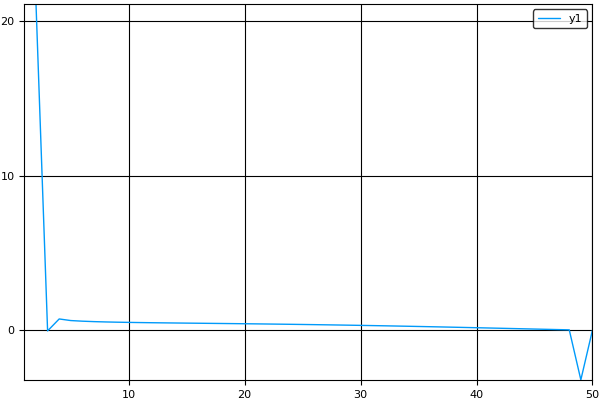

In [22]:
plot(dqdt(.1,sol(0.3)))

## Adding in MTZ Length Functionality

This is my bus ride tomorrow morning.

We must create a few new variables in our ODE. Firstly, we create a function, $q^{tot}$, which gives the overall concentration inside the particle. We can either calculate this as a volume-weighted average of the qi's, or by integrating $J_{N+1/2}$ over time (accounting for the initial concentration, of course.) I'll do both, and compare the results. We then must calculate the gas-phase concentration, which for constant-pattern behaviour is given by $c=c_0q/q_0$ (under certain assumptions). We then calculate $q^*$ from the Langmuir isotherm. 

In [69]:
using DifferentialEquations
using Plots

(D,R,qmax,b,c0) = [1.0,1.0,2.0,1.0,1.0]
q0 = qmax*b*c0/(1+b*c0)
function dqdtMTZ(t,q)
    N = length(q)
    Δr = R/N
    r = Δr/2:Δr:(R-Δr/2)
    qdot = zeros(N)
    J = zeros(N+1)
    rboundary = zeros(N+1)
    rboundary[1] = 0
    rboundary[N+1] = R
    qtot = sum([q[i]*4*pi*((r[i]+Δr)^2 - (r[i]-Δr)^2) for i = 1:N]/(4/3*pi*R^3))
    c = c0*qtot/q0
    qstar = qmax*b*c/(1+b*c)
    J[1] = 0
    J[N+1] = -D*(qstar-q[N])/(Δr/2)
    for i = 2:N
        J[i] = -D*(q[i]-q[i-1])/Δr
        rboundary[i] = (r[i]+r[i-1])/2
    end
    for i = 1:N
        qdot[i] = -D/r[i]^2*(rboundary[i+1]*J[i+1] - rboundary[i]*J[i])/Δr
    end
    return qdot
end

qinit = zeros(30)+0.001
tspan = (0.0,1.0)
prob = ODEProblem(dqdtMTZ,qinit,tspan)
sol = solve(prob)

DiffEqBase.ODESolution{Array{Array{Float64,1},1},Void,Void,Array{Float64,1},Array{Array{Array{Float64,1},1},1},DiffEqBase.ODEProblem{Array{Float64,1},Float64,false,#dqdtMTZ,DiffEqBase.CallbackSet{Tuple{},Tuple{}}},OrdinaryDiffEq.Tsit5,OrdinaryDiffEq.InterpolationData{#dqdtMTZ,Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}}}(Array{Float64,1}[[0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001  …  0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001],[0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001  …  0.001,0.001,0.001,0.001,0.00100001,0.00100015,0.00100315,0.00104574,0.00154589,0.00572558],[0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001  …  0.001,0.001,0.001,0.00100001,0.00100013,0.0010016,0.0010179,0.00116758,0.00227119,0.00825123],[0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001  …  0.001,0.001,0.00100002,0.00100022,0.00100186,0.00101446,0.00109961,0.

In [70]:
i=1; cstore = zeros(100); tstore = zeros(100)
for t = linspace(0,1.0,100)
    q = sol(t)
    N = length(q)
    Δr = R/N
    r = Δr/2:Δr:(R-Δr/2)
    qtot = sum([q[i]*4*pi*((r[i]+Δr)^2 - (r[i]-Δr)^2) for i = 1:N]/(4/3*pi*R^3))
    c = c0*qtot/q0
    tstore[i] = t
    cstore[i] = c
    i = i + 1
end


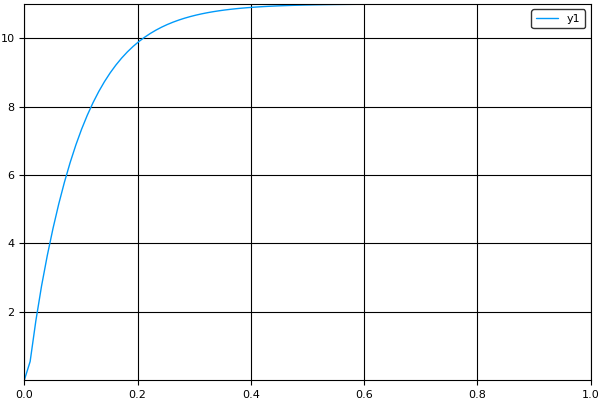

In [71]:
plot(tstore, cstore)